In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import json
import os
import re

def prepare_data(pth_json, pth_models, pth_offers):
    def is_top_5(category_rankings):
        for i in category_rankings:
            for k in range(5 - len(category_rankings[i])): # все предикты top-k делаем длиной 5
                category_rankings[i].append((0, 0, 0))#((index_of_first, 0, 0))#(category_rankings[i][- 1])
            assert len(category_rankings[i]) == 5
        return category_rankings
    
    with open(pth_json, 'r') as fp:
        data = json.load(fp)

    data = {int(k):v for k,v in data.items()} #  a list of (passage_id, rank, score) for the top-k passages
    data = is_top_5(data)

    df_models = pd.read_csv(pth_models, sep=";")
    df_models = df_models.drop(columns=['average_price', 'comment'])
    df_offers = pd.read_csv(pth_offers, sep=";")
    df_offers = df_offers.drop(columns=['true_match', 'false_match'])

    for i in data: # data[i] is a list of (passage_id, rank, score) for the top-k passages
        model_ids = [df_models.iloc[x[0]].model_id for x in data[i]]
        confidences = [x[2] for x in data[i]]

        df_offers.at[i, 'model_id_pred'] = f"{model_ids[0]},{model_ids[1]},{model_ids[2]},{model_ids[3]},{model_ids[4]}"
        df_offers.at[i,'confidence'] = f"{confidences[0]},{confidences[1]},{confidences[2]},{confidences[3]},{confidences[4]}"

    df_offers = df_offers.iloc[list(data.keys())].reset_index(drop=True)

    def split(x):
        return [int(i) for i in x.split(",")]
    def split2(x):
        return [float(i) for i in x.split(",")]

    df_offers['model_id_pred'] = df_offers['model_id_pred'].apply(split)
    df_offers['confidence'] = df_offers['confidence'].apply(split2)

    return data, df_models, df_offers

def accuracy_top_n(offer_model_id, offer_model_id_pred, top_k):
    correct_predictions = 0

    for true_id, predicted_ids in zip(offer_model_id, offer_model_id_pred):
        top_k_predictions = predicted_ids[:top_k]
        if true_id in top_k_predictions:
            correct_predictions += 1

    accuracy = correct_predictions / len(offer_model_id)
    return accuracy

def calculate_precision_recall(offer_model_id, offer_model_id_pred, top_k): # проверить функцию
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for true_id, predicted_ids in zip(offer_model_id, offer_model_id_pred):
        top_k_predictions = predicted_ids[:top_k]
        
        if true_id in top_k_predictions:
            true_positives += 1
        else:
            false_negatives += 1
            false_positives += (true_id in predicted_ids)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

def calc_acc_for_category(df_offers, df_models, imya_kategorii):
    print(f"{imya_kategorii}")
    df_offers = df_offers[df_offers.category_name == imya_kategorii]
    df_models = df_models[df_models.category_name == imya_kategorii]

    offer_names = list(df_offers['name'])
    offer_model_id = list(df_offers['model_id'])
    offer_model_id_pred = list(df_offers['model_id_pred'])

    model_full_names = list(df_models['full_name'])

    # print(f"\tофферов {len(offer_model_id)} шт поиск матча для каждого среди {len(model_full_names)} шт моделей:\n")

    top1_accuracy = accuracy_top_n(offer_model_id, offer_model_id_pred, 1)
    top3_accuracy = accuracy_top_n(offer_model_id, offer_model_id_pred, 3)
    top5_accuracy = accuracy_top_n(offer_model_id, offer_model_id_pred, 5)

    top1_precision, top1_recall = calculate_precision_recall(offer_model_id, offer_model_id_pred, top_k=1)
    top3_precision, top3_recall = calculate_precision_recall(offer_model_id, offer_model_id_pred, top_k=3)
    top5_precision, top5_recall = calculate_precision_recall(offer_model_id, offer_model_id_pred, top_k=5)

    print(f'\tTop-1: Accuracy = {top1_accuracy:.2%}')
    print(f'\tTop-3: Accuracy = {top3_accuracy:.2%}')
    print(f'\tTop-5: Accuracy = {top5_accuracy:.2%}\n')

    # print(f'\tTop-1: Accuracy = {top1_accuracy:.2%}, Precision = {top1_precision:.2%}, Recall = {top1_recall:.2%}')
    # print(f'\tTop-3: Accuracy = {top3_accuracy:.2%}, Precision = {top3_precision:.2%}, Recall = {top3_recall:.2%}')
    # print(f'\tTop-5: Accuracy = {top5_accuracy:.2%}, Precision = {top5_precision:.2%}, Recall = {top5_recall:.2%}\n')
    return top1_accuracy, top3_accuracy, top5_accuracy

In [2]:
pth_models = "/home/sondors/Documents/price/ColBERT_data/18_categories/test/models_18_categories.csv"
pth_offers = "/home/sondors/Documents/price/ColBERT_data/18_categories/test/triplets_test_18_categories.csv"
pth_fld_json = "/home/sondors/Documents/price/ColBERT_data/13_categories/metrics_data/categories_sep/triplets_X1_13_categories_shuffle/json"
# pth_fld_json = "/home/sondors/Documents/price/ColBERT_data/18_categories/metrics_data/categories_sep/triplets_shuffle/json"

categories = [
    "диктофоны, портативные рекордеры",
    "электронные книги",
    "автомобильные телевизоры, мониторы",
    "смарт-часы и браслеты",
    "портативные медиаплееры",
    "чехлы, обложки для гаджетов (телефонов, планшетов etc)",
    "портативная акустика",
    "мобильные телефоны",
    "VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)",
    "планшетные компьютеры и мини-планшеты",
    "наушники, гарнитуры, наушники c микрофоном",
    "радиоприемники, радиобудильники, радиочасы",
    "магнитолы",
    "GPS-навигаторы"
    ]

filenames_int = []
accuracy_all_models = []
for pth in os.listdir(pth_fld_json):
    print(pth)
    pth_json = os.path.join(pth_fld_json, pth)
    # filenames_int.append(int(pth[len("triples_X3_colbert-"):len("triples_shuffle_colbert-")+4]))
    filenames_int.append(int(re.sub(r"[^0-9]","", pth[len("triples_X1_13_categories_shuffle_colbert-"):])))

    data, df_models, df_offers = prepare_data(pth_json, pth_models, pth_offers)

    accuracy_one_model = []
    for category in categories:
        top1_accuracy, top3_accuracy, top5_accuracy = calc_acc_for_category(df_offers, df_models, category)
        accuracy_one_model.append(top1_accuracy)
    accuracy_all_models.append(accuracy_one_model)
accuracy_all_categories = list(map(list, zip(*accuracy_all_models)))

triples_X3_colbert-20000-finish.json


/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 66.93%
	Top-3: Accuracy = 81.27%
	Top-5: Accuracy = 86.06%

электронные книги
	Top-1: Accuracy = 55.31%
	Top-3: Accuracy = 73.30%
	Top-5: Accuracy = 80.93%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 44.00%
	Top-3: Accuracy = 63.00%
	Top-5: Accuracy = 63.00%

смарт-часы и браслеты
	Top-1: Accuracy = 46.49%
	Top-3: Accuracy = 65.95%
	Top-5: Accuracy = 74.26%

портативные медиаплееры
	Top-1: Accuracy = 51.61%
	Top-3: Accuracy = 75.21%
	Top-5: Accuracy = 82.00%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 3.63%
	Top-3: Accuracy = 7.22%
	Top-5: Accuracy = 9.38%

портативная акустика
	Top-1: Accuracy = 37.81%
	Top-3: Accuracy = 53.62%
	Top-5: Accuracy = 59.60%

мобильные телефоны
	Top-1: Accuracy = 27.90%
	Top-3: Accuracy = 42.44%
	Top-5: Accuracy = 50.91%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 45.13%
	Top-3: Accuracy = 67.18%
	Top

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 77.29%
	Top-3: Accuracy = 88.05%
	Top-5: Accuracy = 90.44%

электронные книги
	Top-1: Accuracy = 72.21%
	Top-3: Accuracy = 85.83%
	Top-5: Accuracy = 92.64%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 58.00%
	Top-3: Accuracy = 69.00%
	Top-5: Accuracy = 70.00%

смарт-часы и браслеты
	Top-1: Accuracy = 62.62%
	Top-3: Accuracy = 78.94%
	Top-5: Accuracy = 85.48%

портативные медиаплееры
	Top-1: Accuracy = 69.44%
	Top-3: Accuracy = 83.02%
	Top-5: Accuracy = 86.25%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 17.59%
	Top-3: Accuracy = 30.52%
	Top-5: Accuracy = 36.89%

портативная акустика
	Top-1: Accuracy = 58.35%
	Top-3: Accuracy = 71.20%
	Top-5: Accuracy = 75.30%

мобильные телефоны
	Top-1: Accuracy = 37.49%
	Top-3: Accuracy = 51.82%
	Top-5: Accuracy = 59.12%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 43.08%
	Top-3: Accuracy = 71.79%
	

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 74.90%
	Top-3: Accuracy = 86.85%
	Top-5: Accuracy = 89.24%

электронные книги
	Top-1: Accuracy = 64.58%
	Top-3: Accuracy = 83.11%
	Top-5: Accuracy = 86.92%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 55.00%
	Top-3: Accuracy = 64.00%
	Top-5: Accuracy = 69.00%

смарт-часы и браслеты
	Top-1: Accuracy = 58.80%
	Top-3: Accuracy = 76.74%
	Top-5: Accuracy = 83.73%

портативные медиаплееры
	Top-1: Accuracy = 65.87%
	Top-3: Accuracy = 81.15%
	Top-5: Accuracy = 83.19%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 16.07%
	Top-3: Accuracy = 28.30%
	Top-5: Accuracy = 34.51%

портативная акустика
	Top-1: Accuracy = 57.22%
	Top-3: Accuracy = 70.15%
	Top-5: Accuracy = 74.01%

мобильные телефоны
	Top-1: Accuracy = 36.09%
	Top-3: Accuracy = 51.61%
	Top-5: Accuracy = 58.17%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 40.51%
	Top-3: Accuracy = 68.21%
	

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 73.71%
	Top-3: Accuracy = 86.45%
	Top-5: Accuracy = 89.64%

электронные книги
	Top-1: Accuracy = 53.41%
	Top-3: Accuracy = 73.84%
	Top-5: Accuracy = 82.83%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 48.00%
	Top-3: Accuracy = 60.00%
	Top-5: Accuracy = 65.00%

смарт-часы и браслеты
	Top-1: Accuracy = 51.45%
	Top-3: Accuracy = 69.80%
	Top-5: Accuracy = 76.64%

портативные медиаплееры
	Top-1: Accuracy = 56.54%
	Top-3: Accuracy = 78.95%
	Top-5: Accuracy = 84.38%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 4.45%
	Top-3: Accuracy = 8.97%
	Top-5: Accuracy = 11.78%

портативная акустика
	Top-1: Accuracy = 42.80%
	Top-3: Accuracy = 58.53%
	Top-5: Accuracy = 64.08%

мобильные телефоны
	Top-1: Accuracy = 28.88%
	Top-3: Accuracy = 45.08%
	Top-5: Accuracy = 53.34%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 46.15%
	Top-3: Accuracy = 69.23%
	To

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 70.52%
	Top-3: Accuracy = 85.26%
	Top-5: Accuracy = 87.25%

электронные книги
	Top-1: Accuracy = 59.67%
	Top-3: Accuracy = 75.20%
	Top-5: Accuracy = 83.38%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 51.00%
	Top-3: Accuracy = 60.00%
	Top-5: Accuracy = 64.00%

смарт-часы и браслеты
	Top-1: Accuracy = 51.42%
	Top-3: Accuracy = 70.31%
	Top-5: Accuracy = 78.12%

портативные медиаплееры
	Top-1: Accuracy = 57.39%
	Top-3: Accuracy = 80.65%
	Top-5: Accuracy = 85.74%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 4.54%
	Top-3: Accuracy = 8.94%
	Top-5: Accuracy = 11.43%

портативная акустика
	Top-1: Accuracy = 44.43%
	Top-3: Accuracy = 61.37%
	Top-5: Accuracy = 67.01%

мобильные телефоны
	Top-1: Accuracy = 26.49%
	Top-3: Accuracy = 42.89%
	Top-5: Accuracy = 50.56%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 44.62%
	Top-3: Accuracy = 71.79%
	To

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 67.33%
	Top-3: Accuracy = 84.46%
	Top-5: Accuracy = 87.25%

электронные книги
	Top-1: Accuracy = 59.95%
	Top-3: Accuracy = 74.66%
	Top-5: Accuracy = 80.93%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 43.00%
	Top-3: Accuracy = 58.00%
	Top-5: Accuracy = 64.00%

смарт-часы и браслеты
	Top-1: Accuracy = 47.92%
	Top-3: Accuracy = 66.38%
	Top-5: Accuracy = 75.16%

портативные медиаплееры
	Top-1: Accuracy = 56.03%
	Top-3: Accuracy = 75.55%
	Top-5: Accuracy = 80.65%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 4.25%
	Top-3: Accuracy = 8.85%
	Top-5: Accuracy = 11.48%

портативная акустика
	Top-1: Accuracy = 41.91%
	Top-3: Accuracy = 58.13%
	Top-5: Accuracy = 63.58%

мобильные телефоны
	Top-1: Accuracy = 28.84%
	Top-3: Accuracy = 42.88%
	Top-5: Accuracy = 48.71%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 46.67%
	Top-3: Accuracy = 68.72%
	To

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 68.13%
	Top-3: Accuracy = 85.26%
	Top-5: Accuracy = 88.45%

электронные книги
	Top-1: Accuracy = 57.49%
	Top-3: Accuracy = 70.57%
	Top-5: Accuracy = 76.57%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 42.00%
	Top-3: Accuracy = 59.00%
	Top-5: Accuracy = 60.00%

смарт-часы и браслеты
	Top-1: Accuracy = 43.53%
	Top-3: Accuracy = 64.52%
	Top-5: Accuracy = 73.01%

портативные медиаплееры
	Top-1: Accuracy = 48.56%
	Top-3: Accuracy = 70.63%
	Top-5: Accuracy = 78.27%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 3.41%
	Top-3: Accuracy = 6.79%
	Top-5: Accuracy = 9.10%

портативная акустика
	Top-1: Accuracy = 35.24%
	Top-3: Accuracy = 49.83%
	Top-5: Accuracy = 56.99%

мобильные телефоны
	Top-1: Accuracy = 26.66%
	Top-3: Accuracy = 41.34%
	Top-5: Accuracy = 48.77%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 42.56%
	Top-3: Accuracy = 68.21%
	Top

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 70.52%
	Top-3: Accuracy = 84.46%
	Top-5: Accuracy = 87.25%

электронные книги
	Top-1: Accuracy = 56.68%
	Top-3: Accuracy = 73.57%
	Top-5: Accuracy = 78.20%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 46.00%
	Top-3: Accuracy = 61.00%
	Top-5: Accuracy = 63.00%

смарт-часы и браслеты
	Top-1: Accuracy = 44.02%
	Top-3: Accuracy = 64.43%
	Top-5: Accuracy = 72.86%

портативные медиаплееры
	Top-1: Accuracy = 48.22%
	Top-3: Accuracy = 71.14%
	Top-5: Accuracy = 78.78%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 3.45%
	Top-3: Accuracy = 7.09%
	Top-5: Accuracy = 9.35%

портативная акустика
	Top-1: Accuracy = 35.63%
	Top-3: Accuracy = 49.99%
	Top-5: Accuracy = 55.90%

мобильные телефоны
	Top-1: Accuracy = 27.48%
	Top-3: Accuracy = 41.85%
	Top-5: Accuracy = 49.82%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 40.51%
	Top-3: Accuracy = 66.15%
	Top

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 74.90%
	Top-3: Accuracy = 88.05%
	Top-5: Accuracy = 89.24%

электронные книги
	Top-1: Accuracy = 54.50%
	Top-3: Accuracy = 75.48%
	Top-5: Accuracy = 82.02%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 51.00%
	Top-3: Accuracy = 63.00%
	Top-5: Accuracy = 66.00%

смарт-часы и браслеты
	Top-1: Accuracy = 53.30%
	Top-3: Accuracy = 71.79%
	Top-5: Accuracy = 78.88%

портативные медиаплееры
	Top-1: Accuracy = 61.29%
	Top-3: Accuracy = 80.98%
	Top-5: Accuracy = 84.72%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 8.77%
	Top-3: Accuracy = 16.70%
	Top-5: Accuracy = 21.28%

портативная акустика
	Top-1: Accuracy = 50.06%
	Top-3: Accuracy = 64.71%
	Top-5: Accuracy = 69.58%

мобильные телефоны
	Top-1: Accuracy = 29.26%
	Top-3: Accuracy = 41.92%
	Top-5: Accuracy = 49.69%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 39.49%
	Top-3: Accuracy = 69.23%
	T

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 72.91%
	Top-3: Accuracy = 85.66%
	Top-5: Accuracy = 88.84%

электронные книги
	Top-1: Accuracy = 57.49%
	Top-3: Accuracy = 74.11%
	Top-5: Accuracy = 78.47%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 45.00%
	Top-3: Accuracy = 61.00%
	Top-5: Accuracy = 63.00%

смарт-часы и браслеты
	Top-1: Accuracy = 43.99%
	Top-3: Accuracy = 64.54%
	Top-5: Accuracy = 72.83%

портативные медиаплееры
	Top-1: Accuracy = 46.86%
	Top-3: Accuracy = 71.14%
	Top-5: Accuracy = 79.46%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 3.43%
	Top-3: Accuracy = 7.30%
	Top-5: Accuracy = 9.58%

портативная акустика
	Top-1: Accuracy = 34.83%
	Top-3: Accuracy = 49.64%
	Top-5: Accuracy = 56.24%

мобильные телефоны
	Top-1: Accuracy = 27.59%
	Top-3: Accuracy = 41.58%
	Top-5: Accuracy = 49.66%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 40.00%
	Top-3: Accuracy = 66.67%
	Top

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 69.72%
	Top-3: Accuracy = 86.06%
	Top-5: Accuracy = 88.45%

электронные книги
	Top-1: Accuracy = 58.31%
	Top-3: Accuracy = 74.93%
	Top-5: Accuracy = 81.20%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 47.00%
	Top-3: Accuracy = 60.00%
	Top-5: Accuracy = 64.00%

смарт-часы и браслеты
	Top-1: Accuracy = 48.38%
	Top-3: Accuracy = 67.06%
	Top-5: Accuracy = 74.77%

портативные медиаплееры
	Top-1: Accuracy = 54.33%
	Top-3: Accuracy = 76.06%
	Top-5: Accuracy = 82.34%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 3.38%
	Top-3: Accuracy = 6.81%
	Top-5: Accuracy = 8.90%

портативная акустика
	Top-1: Accuracy = 38.36%
	Top-3: Accuracy = 55.99%
	Top-5: Accuracy = 60.65%

мобильные телефоны
	Top-1: Accuracy = 30.34%
	Top-3: Accuracy = 44.37%
	Top-5: Accuracy = 52.10%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 43.08%
	Top-3: Accuracy = 68.72%
	Top

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 71.31%
	Top-3: Accuracy = 82.87%
	Top-5: Accuracy = 86.45%

электронные книги
	Top-1: Accuracy = 56.40%
	Top-3: Accuracy = 75.20%
	Top-5: Accuracy = 82.02%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 51.00%
	Top-3: Accuracy = 63.00%
	Top-5: Accuracy = 65.00%

смарт-часы и браслеты
	Top-1: Accuracy = 50.11%
	Top-3: Accuracy = 69.39%
	Top-5: Accuracy = 76.41%

портативные медиаплееры
	Top-1: Accuracy = 55.35%
	Top-3: Accuracy = 76.74%
	Top-5: Accuracy = 82.00%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 3.92%
	Top-3: Accuracy = 8.02%
	Top-5: Accuracy = 10.50%

портативная акустика
	Top-1: Accuracy = 48.00%
	Top-3: Accuracy = 63.33%
	Top-5: Accuracy = 68.43%

мобильные телефоны
	Top-1: Accuracy = 26.76%
	Top-3: Accuracy = 39.78%
	Top-5: Accuracy = 46.66%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 40.00%
	Top-3: Accuracy = 60.51%
	To

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 66.53%
	Top-3: Accuracy = 82.47%
	Top-5: Accuracy = 87.25%

электронные книги
	Top-1: Accuracy = 55.04%
	Top-3: Accuracy = 73.57%
	Top-5: Accuracy = 78.47%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 45.00%
	Top-3: Accuracy = 59.00%
	Top-5: Accuracy = 62.00%

смарт-часы и браслеты
	Top-1: Accuracy = 45.36%
	Top-3: Accuracy = 64.15%
	Top-5: Accuracy = 72.97%

портативные медиаплееры
	Top-1: Accuracy = 50.76%
	Top-3: Accuracy = 72.84%
	Top-5: Accuracy = 80.31%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 4.63%
	Top-3: Accuracy = 9.73%
	Top-5: Accuracy = 12.30%

портативная акустика
	Top-1: Accuracy = 36.95%
	Top-3: Accuracy = 51.16%
	Top-5: Accuracy = 57.53%

мобильные телефоны
	Top-1: Accuracy = 28.54%
	Top-3: Accuracy = 42.99%
	Top-5: Accuracy = 50.66%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 44.62%
	Top-3: Accuracy = 72.31%
	To

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 65.74%
	Top-3: Accuracy = 84.86%
	Top-5: Accuracy = 87.65%

электронные книги
	Top-1: Accuracy = 56.68%
	Top-3: Accuracy = 72.48%
	Top-5: Accuracy = 79.29%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 45.00%
	Top-3: Accuracy = 59.00%
	Top-5: Accuracy = 61.00%

смарт-часы и браслеты
	Top-1: Accuracy = 45.18%
	Top-3: Accuracy = 66.56%
	Top-5: Accuracy = 74.78%

портативные медиаплееры
	Top-1: Accuracy = 51.44%
	Top-3: Accuracy = 73.85%
	Top-5: Accuracy = 81.66%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 4.25%
	Top-3: Accuracy = 8.81%
	Top-5: Accuracy = 11.43%

портативная акустика
	Top-1: Accuracy = 37.41%
	Top-3: Accuracy = 51.85%
	Top-5: Accuracy = 57.52%

мобильные телефоны
	Top-1: Accuracy = 27.99%
	Top-3: Accuracy = 43.30%
	Top-5: Accuracy = 51.50%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 42.05%
	Top-3: Accuracy = 68.21%
	To

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 68.53%
	Top-3: Accuracy = 86.06%
	Top-5: Accuracy = 89.64%

электронные книги
	Top-1: Accuracy = 59.40%
	Top-3: Accuracy = 76.57%
	Top-5: Accuracy = 83.11%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 51.00%
	Top-3: Accuracy = 59.00%
	Top-5: Accuracy = 63.00%

смарт-часы и браслеты
	Top-1: Accuracy = 53.05%
	Top-3: Accuracy = 72.69%
	Top-5: Accuracy = 79.20%

портативные медиаплееры
	Top-1: Accuracy = 57.22%
	Top-3: Accuracy = 80.81%
	Top-5: Accuracy = 86.42%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 4.65%
	Top-3: Accuracy = 9.31%
	Top-5: Accuracy = 12.06%

портативная акустика
	Top-1: Accuracy = 46.09%
	Top-3: Accuracy = 62.44%
	Top-5: Accuracy = 68.11%

мобильные телефоны
	Top-1: Accuracy = 28.92%
	Top-3: Accuracy = 46.40%
	Top-5: Accuracy = 53.89%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 43.08%
	Top-3: Accuracy = 67.69%
	To

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 67.33%
	Top-3: Accuracy = 83.67%
	Top-5: Accuracy = 86.85%

электронные книги
	Top-1: Accuracy = 55.04%
	Top-3: Accuracy = 73.57%
	Top-5: Accuracy = 80.11%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 46.00%
	Top-3: Accuracy = 60.00%
	Top-5: Accuracy = 61.00%

смарт-часы и браслеты
	Top-1: Accuracy = 48.23%
	Top-3: Accuracy = 67.19%
	Top-5: Accuracy = 74.91%

портативные медиаплееры
	Top-1: Accuracy = 52.46%
	Top-3: Accuracy = 75.38%
	Top-5: Accuracy = 81.32%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 3.56%
	Top-3: Accuracy = 7.35%
	Top-5: Accuracy = 9.84%

портативная акустика
	Top-1: Accuracy = 37.44%
	Top-3: Accuracy = 52.49%
	Top-5: Accuracy = 58.18%

мобильные телефоны
	Top-1: Accuracy = 27.46%
	Top-3: Accuracy = 43.91%
	Top-5: Accuracy = 51.82%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 40.00%
	Top-3: Accuracy = 67.18%
	Top

/tmp/ipykernel_10769/2864186926.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	Top-1: Accuracy = 73.31%
	Top-3: Accuracy = 85.66%
	Top-5: Accuracy = 88.84%

электронные книги
	Top-1: Accuracy = 53.95%
	Top-3: Accuracy = 73.30%
	Top-5: Accuracy = 82.29%

автомобильные телевизоры, мониторы
	Top-1: Accuracy = 46.00%
	Top-3: Accuracy = 60.00%
	Top-5: Accuracy = 62.00%

смарт-часы и браслеты
	Top-1: Accuracy = 47.21%
	Top-3: Accuracy = 65.86%
	Top-5: Accuracy = 74.24%

портативные медиаплееры
	Top-1: Accuracy = 53.82%
	Top-3: Accuracy = 75.55%
	Top-5: Accuracy = 83.02%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	Top-1: Accuracy = 3.85%
	Top-3: Accuracy = 7.87%
	Top-5: Accuracy = 10.58%

портативная акустика
	Top-1: Accuracy = 38.83%
	Top-3: Accuracy = 56.18%
	Top-5: Accuracy = 61.60%

мобильные телефоны
	Top-1: Accuracy = 27.08%
	Top-3: Accuracy = 41.97%
	Top-5: Accuracy = 48.79%

VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)
	Top-1: Accuracy = 43.08%
	Top-3: Accuracy = 65.64%
	To

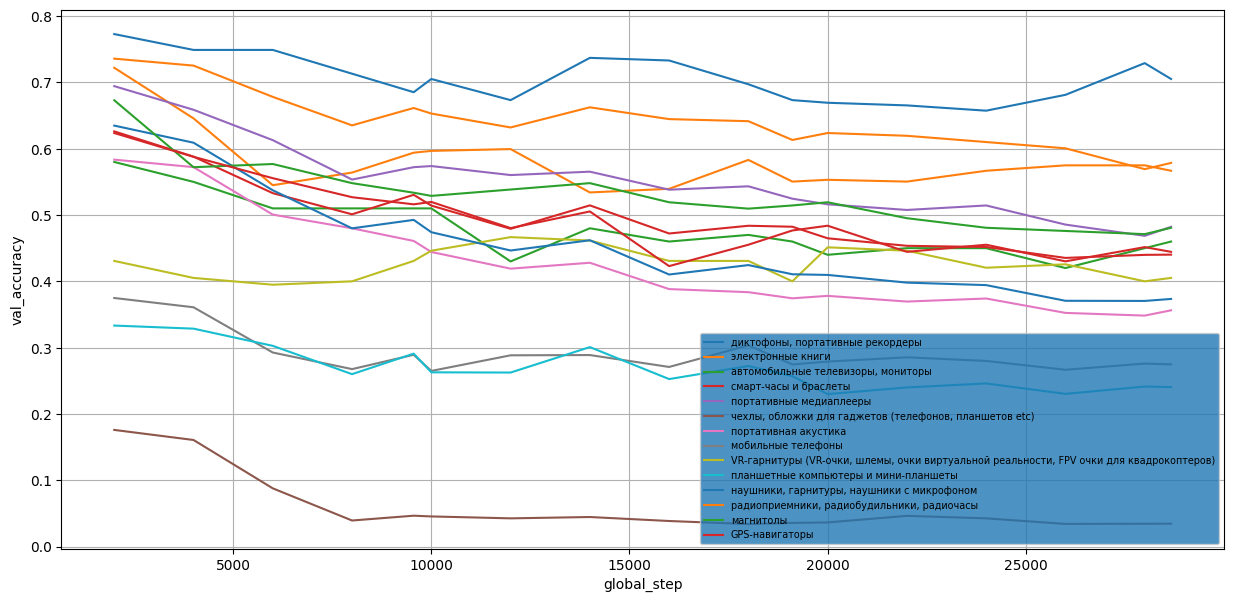

In [3]:
def plot_epochs_accuracy(filenames_int, accuracy_all, categories, y_axe='val_accuracy', x_axe='epoch'):
    plt.rcParams['figure.figsize'] = [15, 7]
    fig, ax = plt.subplots()

    for i in range(len(categories)):
        ax.plot(filenames_int, accuracy_all[i], label=categories[i])
    plt.xlabel(x_axe)
    plt.ylabel(y_axe)


    legend = ax.legend(loc='lower right', shadow=False, fontsize='x-small')

    # Put a nicer background color on the legend.
    legend.get_frame().set_facecolor('C0')
    plt.grid()
    plt.show()

filenames_int_sorted, accuracy_all_models_sorted = zip(*sorted(zip(filenames_int, accuracy_all_models))) # если веса перемешаны
accuracy_all_categories_sorted = list(map(list, zip(*accuracy_all_models_sorted)))# нужны эти две строки кода для корректной отрисовки

plot_epochs_accuracy(filenames_int_sorted, accuracy_all_categories_sorted, categories, y_axe='val_accuracy', x_axe='global_step')

In [4]:
filenames_int

[20000,
 2000,
 4000,
 14000,
 10000,
 12000,
 26000,
 28665,
 6000,
 28000,
 18000,
 8000,
 22000,
 24000,
 9555,
 19110,
 16000]